# Credit Card Fraud Detection Project
## Complete notebook for detecting fraudulent transactions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

In [2]:
# DATA LOADING AND INITIAL EXPLORATION

# Loading training and test datasets

df_train = pd.read_csv('./data/fraudtrain.csv', index_col = 0)
df_test = pd.read_csv('./data/fraudtest.csv', index_col = 0)
print(f"✓ Training data loaded: {df_train.shape}")
print(f"✓ Test data loaded: {df_test.shape}")

print("\n\n")
print(df_train.head())

print("\n Training Data Info:")
print(df_train.info())
    
print("\n Target variable distribution:")
if 'is_fraud' in df_train.columns:
    fraud_counts = df_train['is_fraud'].value_counts()
    print(fraud_counts)
    print(f"Fraud rate: {fraud_counts[1]/len(df_train)*100:.2f}%")

✓ Training data loaded: (1296675, 22)
✓ Test data loaded: (555719, 22)



  trans_date_trans_time            cc_num                            merchant  \
0   2019-01-01 00:00:18  2703186189652095          fraud_Rippin, Kub and Mann   
1   2019-01-01 00:00:44      630423337322     fraud_Heller, Gutmann and Zieme   
2   2019-01-01 00:00:51    38859492057661                fraud_Lind-Buckridge   
3   2019-01-01 00:01:16  3534093764340240  fraud_Kutch, Hermiston and Farrell   
4   2019-01-01 00:03:06   375534208663984                 fraud_Keeling-Crist   

        category     amt      first     last gender  \
0       misc_net    4.97   Jennifer    Banks      F   
1    grocery_pos  107.23  Stephanie     Gill      F   
2  entertainment  220.11     Edward  Sanchez      M   
3  gas_transport   45.00     Jeremy    White      M   
4       misc_pos   41.96      Tyler   Garcia      M   

                         street            city  ...      lat      long  \
0                561 Perry Cove  

In [3]:
# DATA PREPROCESSING AND FEATURE ENGINEERING

def preprocess_data(df, is_training=True):
    """
    Comprehensive data preprocessing and feature engineering
    """
    print(f"\n Preprocessing {'training' if is_training else 'test'} data...")
    
    df_processed = df.copy()
    
    # Converting transaction datetime
    if 'trans_date_trans_time' in df_processed.columns:
        df_processed['trans_date_trans_time'] = pd.to_datetime(df_processed['trans_date_trans_time'])
        
        # Extracting datetime features
        df_processed['trans_year'] = df_processed['trans_date_trans_time'].dt.year
        df_processed['trans_month'] = df_processed['trans_date_trans_time'].dt.month
        df_processed['trans_day'] = df_processed['trans_date_trans_time'].dt.day
        df_processed['trans_hour'] = df_processed['trans_date_trans_time'].dt.hour
        df_processed['trans_weekday'] = df_processed['trans_date_trans_time'].dt.weekday
        df_processed['is_weekend'] = (df_processed['trans_weekday'] >= 5).astype(int)
        
        # Time-based features
        df_processed['is_night'] = ((df_processed['trans_hour'] >= 22) | (df_processed['trans_hour'] <= 6)).astype(int)
        df_processed['is_business_hours'] = ((df_processed['trans_hour'] >= 9) & (df_processed['trans_hour'] <= 17)).astype(int)
    
    # Converting DOB to age
    if 'dob' in df_processed.columns:
        df_processed['dob'] = pd.to_datetime(df_processed['dob'])
        df_processed['age'] = (pd.to_datetime('2020-01-01') - df_processed['dob']).dt.days // 365
    
    # Amount-based features
    if 'amt' in df_processed.columns:
        df_processed['amt_log'] = np.log1p(df_processed['amt'])
        df_processed['is_high_amount'] = (df_processed['amt'] > df_processed['amt'].quantile(0.95)).astype(int)
        df_processed['is_round_amount'] = (df_processed['amt'] % 1 == 0).astype(int)
    
    # Merchant and category features
    if 'merchant' in df_processed.columns:
        df_processed['merchant_freq'] = df_processed['merchant'].map(df_processed['merchant'].value_counts())
        df_processed['is_fraud_merchant'] = df_processed['merchant'].str.contains('fraud_', case=False).astype(int)
    
    # Location-based features
    if 'lat' in df_processed.columns and 'long' in df_processed.columns:
        # Distance from center of US (rough calculation)
        center_lat, center_long = 39.8283, -98.5795
        df_processed['dist_from_center'] = np.sqrt((df_processed['lat'] - center_lat)**2 + 
                                                 (df_processed['long'] - center_long)**2)
    
    # Categorical encoding
    categorical_columns = ['category', 'gender', 'job']
    le_dict = {}
    
    for col in categorical_columns:
        if col in df_processed.columns:
            le = LabelEncoder()
            df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col].astype(str))
            if is_training:
                le_dict[col] = le
    
    print(f"✓ Preprocessing complete. Shape: {df_processed.shape}")
    return df_processed, le_dict if is_training else df_processed

# Apply preprocessing
if not df_train.empty:
    df_train_processed, label_encoders = preprocess_data(df_train, is_training=True)
    df_test_processed, _ = preprocess_data(df_test, is_training=False)


 Preprocessing training data...
✓ Preprocessing complete. Shape: (1296675, 40)

 Preprocessing test data...
✓ Preprocessing complete. Shape: (555719, 40)



 Performing Exploratory Data Analysis...


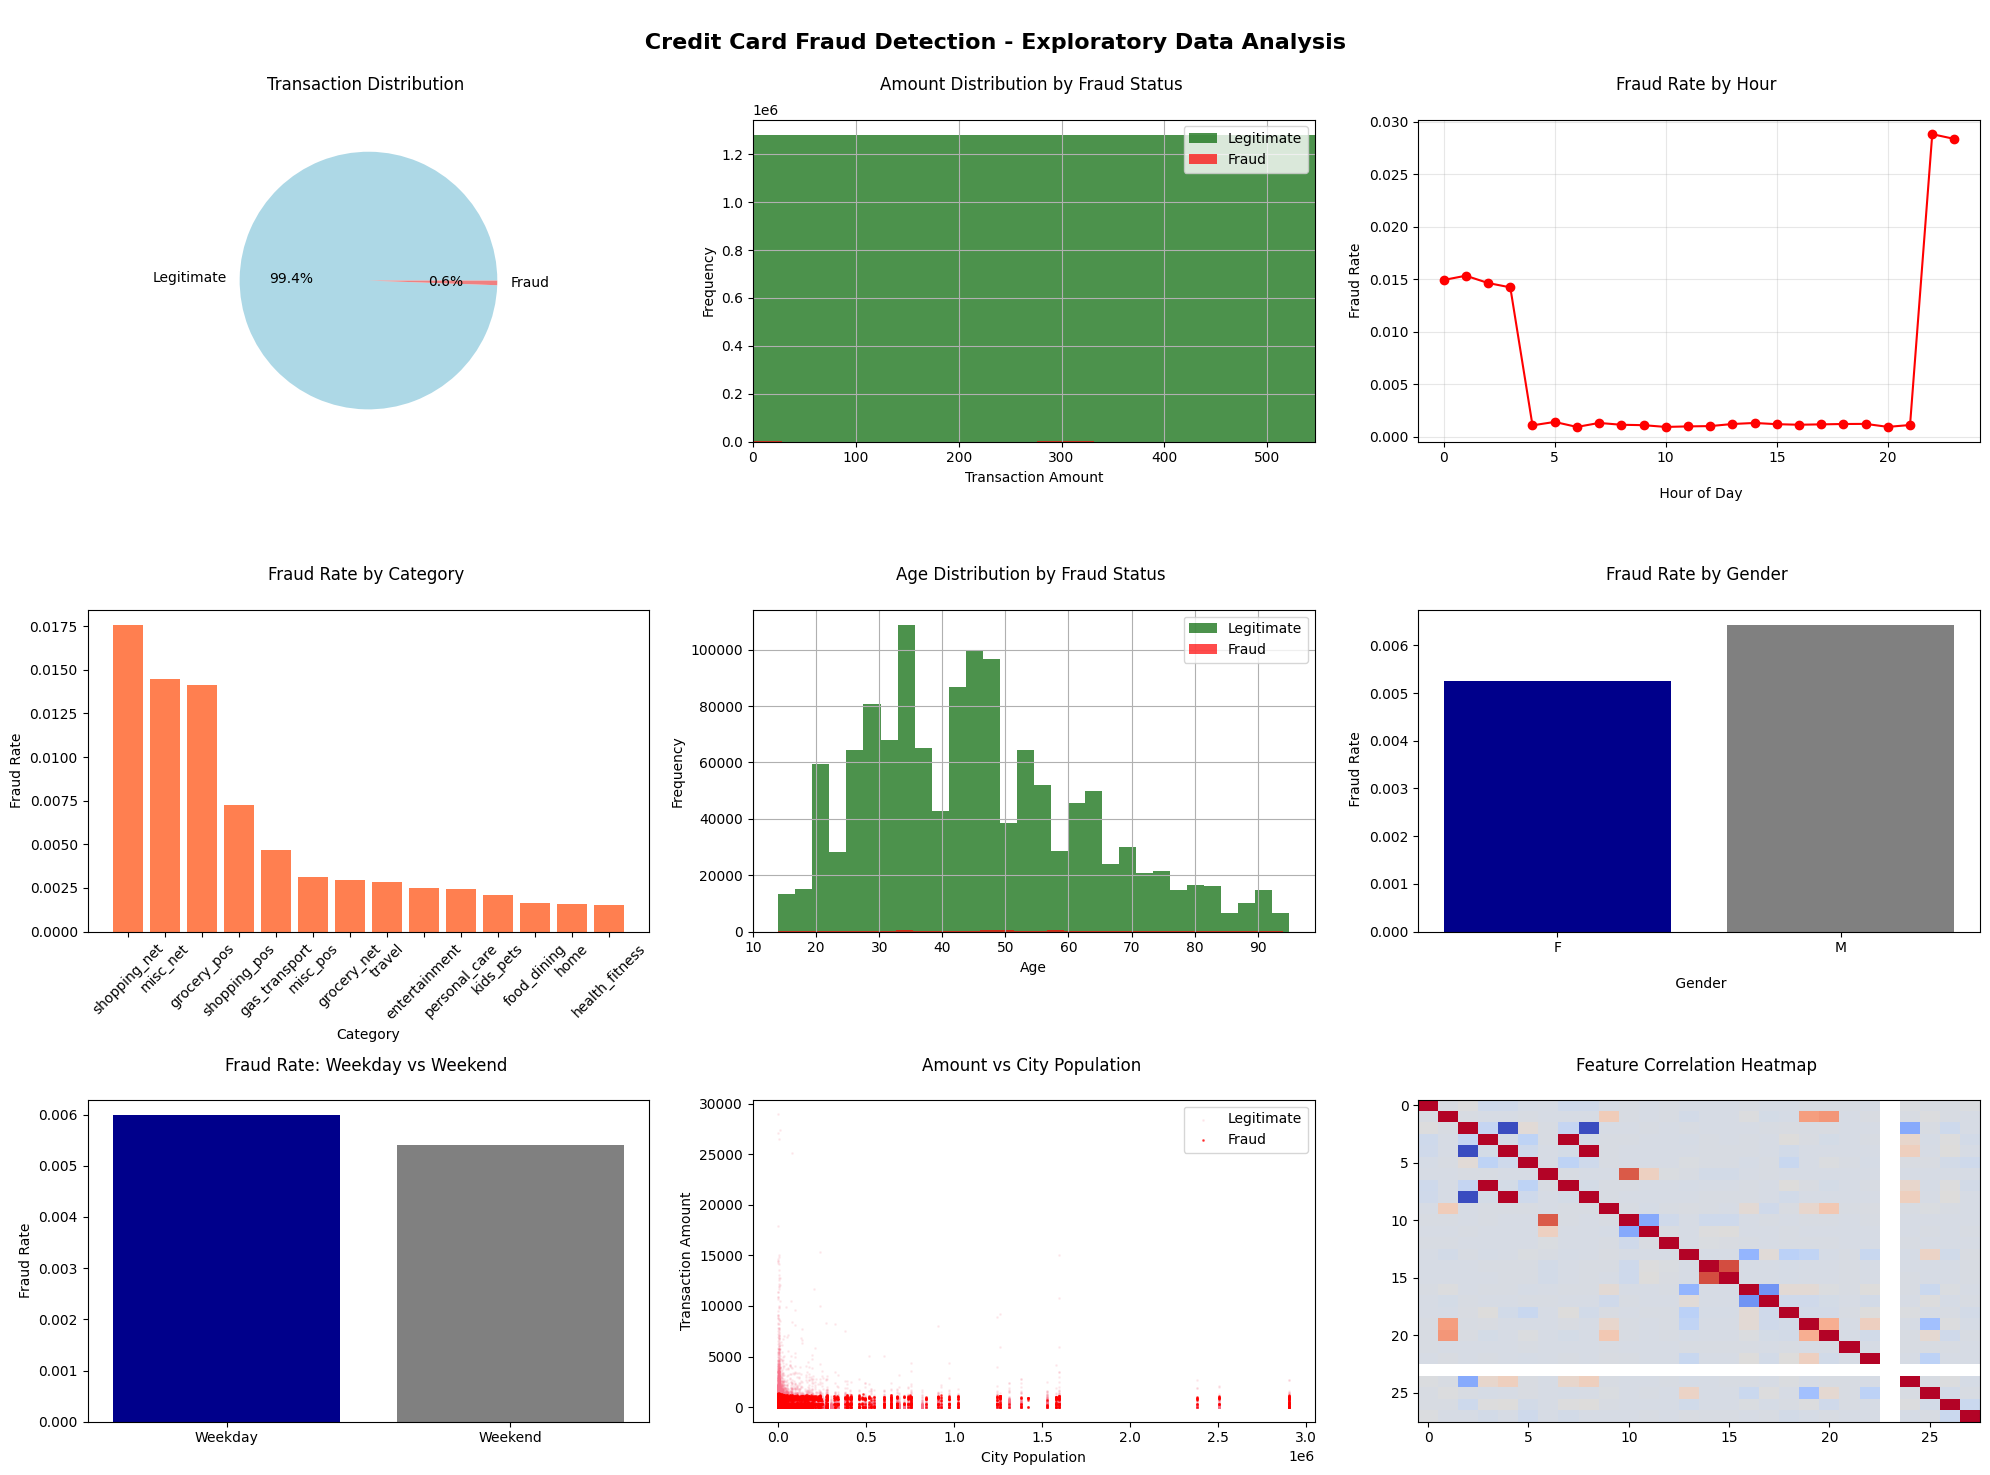


FRAUD ANALYSIS SUMMARY
Total Transactions: 1,296,675
Fraudulent Transactions: 7,506
Fraud Rate: 0.58%

Transaction Amount Statistics:
Average Legitimate Transaction: $67.67
Average Fraudulent Transaction: $531.32
Median Legitimate Transaction: $47.28
Median Fraudulent Transaction: $396.50


In [4]:
# 3. EXPLORATORY DATA ANALYSIS

def perform_eda(df):
    """
    Comprehensive Exploratory Data Analysis
    """
    print("\n Performing Exploratory Data Analysis...")
    
    if 'is_fraud' not in df.columns:
        print("  No 'is_fraud' column found for EDA")
        return
    
    # Set up the plotting area
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('\n Credit Card Fraud Detection - Exploratory Data Analysis \n', fontsize=16, fontweight='bold')
    
    # 1. Fraud distribution
    fraud_counts = df['is_fraud'].value_counts()
    axes[0,0].pie(fraud_counts.values, labels=['Legitimate', 'Fraud'], autopct='%1.1f%%', 
                  colors=['lightblue', 'lightcoral'])
    axes[0,0].set_title('Transaction Distribution \n')
    
    # 2. Amount distribution by fraud
    if 'amt' in df.columns:
        df[df['is_fraud']==0]['amt'].hist(bins=50, alpha=0.7, label='Legitimate', ax=axes[0,1], color= 'darkgreen')
        df[df['is_fraud']==1]['amt'].hist(bins=50, alpha=0.7, label='Fraud', ax=axes[0,1], color= 'red')
        axes[0,1].set_xlabel('Transaction Amount')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].set_title('Amount Distribution by Fraud Status \n')
        axes[0,1].legend()
        axes[0,1].set_xlim(0, df['amt'].quantile(0.99))
    
    # 3. Hourly fraud pattern
    if 'trans_hour' in df.columns:
        hourly_fraud = df.groupby('trans_hour')['is_fraud'].agg(['count', 'sum', 'mean'])
        axes[0,2].plot(hourly_fraud.index, hourly_fraud['mean'], marker='o', color='red')
        axes[0,2].set_xlabel('\n Hour of Day')
        axes[0,2].set_ylabel('Fraud Rate')
        axes[0,2].set_title('Fraud Rate by Hour \n')
        axes[0,2].grid(True, alpha=0.3)
    
    # 4. Category-wise fraud
    if 'category' in df.columns:
        cat_fraud = df.groupby('category')['is_fraud'].agg(['count', 'sum', 'mean']).sort_values('mean', ascending=False)
        axes[1,0].bar(range(len(cat_fraud)), cat_fraud['mean'], color='coral')
        axes[1,0].set_xlabel('Category')
        axes[1,0].set_ylabel('Fraud Rate')
        axes[1,0].set_title('Fraud Rate by Category \n')
        axes[1,0].set_xticks(range(len(cat_fraud)))
        axes[1,0].set_xticklabels(cat_fraud.index, rotation=45)
    
    # 5. Age distribution
    if 'age' in df.columns:
        df[df['is_fraud']==0]['age'].hist(bins=30, alpha=0.7, label='Legitimate', ax=axes[1,1], color= 'darkgreen')
        df[df['is_fraud']==1]['age'].hist(bins=30, alpha=0.7, label='Fraud', ax=axes[1,1], color= 'red')
        axes[1,1].set_xlabel('Age')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].set_title('Age Distribution by Fraud Status \n')
        axes[1,1].legend()
    
    # 6. Gender-wise fraud
    if 'gender' in df.columns:
        gender_fraud = df.groupby('gender')['is_fraud'].agg(['count', 'sum', 'mean'])
        axes[1,2].bar(gender_fraud.index, gender_fraud['mean'], color=['darkblue', 'gray'])
        axes[1,2].set_xlabel('\n Gender')
        axes[1,2].set_ylabel('\n Fraud Rate')
        axes[1,2].set_title('Fraud Rate by Gender \n')
    
    # 7. Weekend vs Weekday fraud
    if 'is_weekend' in df.columns:
        weekend_fraud = df.groupby('is_weekend')['is_fraud'].agg(['count', 'sum', 'mean'])
        axes[2,0].bar(['Weekday', 'Weekend'], weekend_fraud['mean'], color=['darkblue', 'gray'])
        axes[2,0].set_ylabel('Fraud Rate')
        axes[2,0].set_title('Fraud Rate: Weekday vs Weekend \n')
    
    # 8. City population vs fraud
    if 'city_pop' in df.columns:
        axes[2,1].scatter(df[df['is_fraud']==0]['city_pop'], df[df['is_fraud']==0]['amt'], 
                         alpha=0.1, label='Legitimate', s=1)
        axes[2,1].scatter(df[df['is_fraud']==1]['city_pop'], df[df['is_fraud']==1]['amt'], 
                         alpha=0.6, label='Fraud', s=1, color='red')
        axes[2,1].set_xlabel('City Population')
        axes[2,1].set_ylabel('Transaction Amount')
        axes[2,1].set_title('Amount vs City Population \n')
        axes[2,1].legend()
    
    # 9. Correlation heatmap of numerical features
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[numerical_cols].corr()
    im = axes[2,2].imshow(correlation_matrix, cmap='coolwarm', aspect='auto')
    axes[2,2].set_title('Feature Correlation Heatmap \n')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("FRAUD ANALYSIS SUMMARY")
    print("="*60)
    print(f"Total Transactions: {len(df):,}")
    print(f"Fraudulent Transactions: {df['is_fraud'].sum():,}")
    print(f"Fraud Rate: {df['is_fraud'].mean()*100:.2f}%")
    
    if 'amt' in df.columns:
        print(f"\nTransaction Amount Statistics:")
        print(f"Average Legitimate Transaction: ${df[df['is_fraud']==0]['amt'].mean():.2f}")
        print(f"Average Fraudulent Transaction: ${df[df['is_fraud']==1]['amt'].mean():.2f}")
        print(f"Median Legitimate Transaction: ${df[df['is_fraud']==0]['amt'].median():.2f}")
        print(f"Median Fraudulent Transaction: ${df[df['is_fraud']==1]['amt'].median():.2f}")

# Perform EDA
if not df_train_processed.empty:
    perform_eda(df_train_processed)

In [5]:
# FEATURE SELECTION AND MODEL PREPARATION

def prepare_features(df_train, df_test=None):
    """
    Prepare features for machine learning models
    """
    print("\n Preparing features for modeling...")
    
    # Defining features to exclude
    exclude_cols = ['trans_date_trans_time', 'cc_num', 'merchant', 'first', 'last', 
                   'street', 'dob', 'trans_num', 'unix_time', 'is_fraud']
    
    # Getting feature columns
    feature_cols = [col for col in df_train.columns if col not in exclude_cols]
    
    # Handling remaining non-numeric columns
    for col in feature_cols.copy():
        if df_train[col].dtype == 'object':
            print(f" Removing non-numeric column: {col}")
            feature_cols.remove(col)
    
    X_train = df_train[feature_cols]
    y_train = df_train['is_fraud'] if 'is_fraud' in df_train.columns else None
    
    X_test = df_test[feature_cols] if df_test is not None else None
    
    # Handling missing values
    X_train = X_train.fillna(X_train.median())
    if X_test is not None:
        X_test = X_test.fillna(X_train.median())  # Use training medians for test set
    
    print(f"\n ✓ Feature preparation complete")
    print(f"  Training features shape: {X_train.shape}")
    if X_test is not None:
        print(f"  Test features shape: {X_test.shape}")
    print(f"  Selected features: {feature_cols[:10]}..." if len(feature_cols) > 10 else f"  Selected features: {feature_cols}")
    
    return X_train, y_train, X_test, feature_cols

# Prepare features
if not df_train_processed.empty:
    X_train, y_train, X_test, feature_names = prepare_features(df_train_processed, 
                                                               df_test_processed if not df_test_processed.empty else None)


 Preparing features for modeling...
 Removing non-numeric column: category
 Removing non-numeric column: gender
 Removing non-numeric column: city
 Removing non-numeric column: state
 Removing non-numeric column: job

 ✓ Feature preparation complete
  Training features shape: (1296675, 25)
  Test features shape: (555719, 25)
  Selected features: ['amt', 'zip', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'trans_year', 'trans_month', 'trans_day']...


In [10]:
# HANDLING CLASS IMBALANCE

def handle_imbalance(X, y, method='undersample'):
    """
    Handle class imbalance using various techniques
    """
    print(f"\n Handling class imbalance using {method}...")
    
    print(f"Original class distribution:")
    print(f"  Legitimate: {(y==0).sum():,} ({(y==0).mean()*100:.1f}%)")
    print(f"  Fraud: {(y==1).sum():,} ({(y==1).mean()*100:.1f}%)")
    
    if method == 'oversample_smote':
        smote = SMOTE(random_state=42)
        X_balanced, y_balanced = smote.fit_resample(X, y)
    elif method == 'undersample':
        rus = RandomUnderSampler(random_state=42, sampling_strategy=0.5)  # 2:1 ratio
        X_balanced, y_balanced = rus.fit_resample(X, y)
    else:  # no balancing
        X_balanced, y_balanced = X, y
    
    print(f"Balanced class distribution:")
    print(f"  Legitimate: {(y_balanced==0).sum():,} ({(y_balanced==0).mean()*100:.1f}%)")
    print(f"  Fraud: {(y_balanced==1).sum():,} ({(y_balanced==1).mean()*100:.1f}%)")
    
    return X_balanced, y_balanced

# Handling imbalance
if not df_train_processed.empty and y_train is not None:
    X_balanced, y_balanced = handle_imbalance(X_train, y_train, method='undersample')


 Handling class imbalance using undersample...
Original class distribution:
  Legitimate: 1,289,169 (99.4%)
  Fraud: 7,506 (0.6%)
Balanced class distribution:
  Legitimate: 15,012 (66.7%)
  Fraud: 7,506 (33.3%)



 Training and evaluating models...

Training Logistic Regression...
✓ Logistic Regression AUC Score: 0.9564

Training Random Forest...
✓ Random Forest AUC Score: 0.9951

Training Gradient Boosting...
✓ Gradient Boosting AUC Score: 0.9929

 Best Model: Random Forest (AUC: 0.9951)


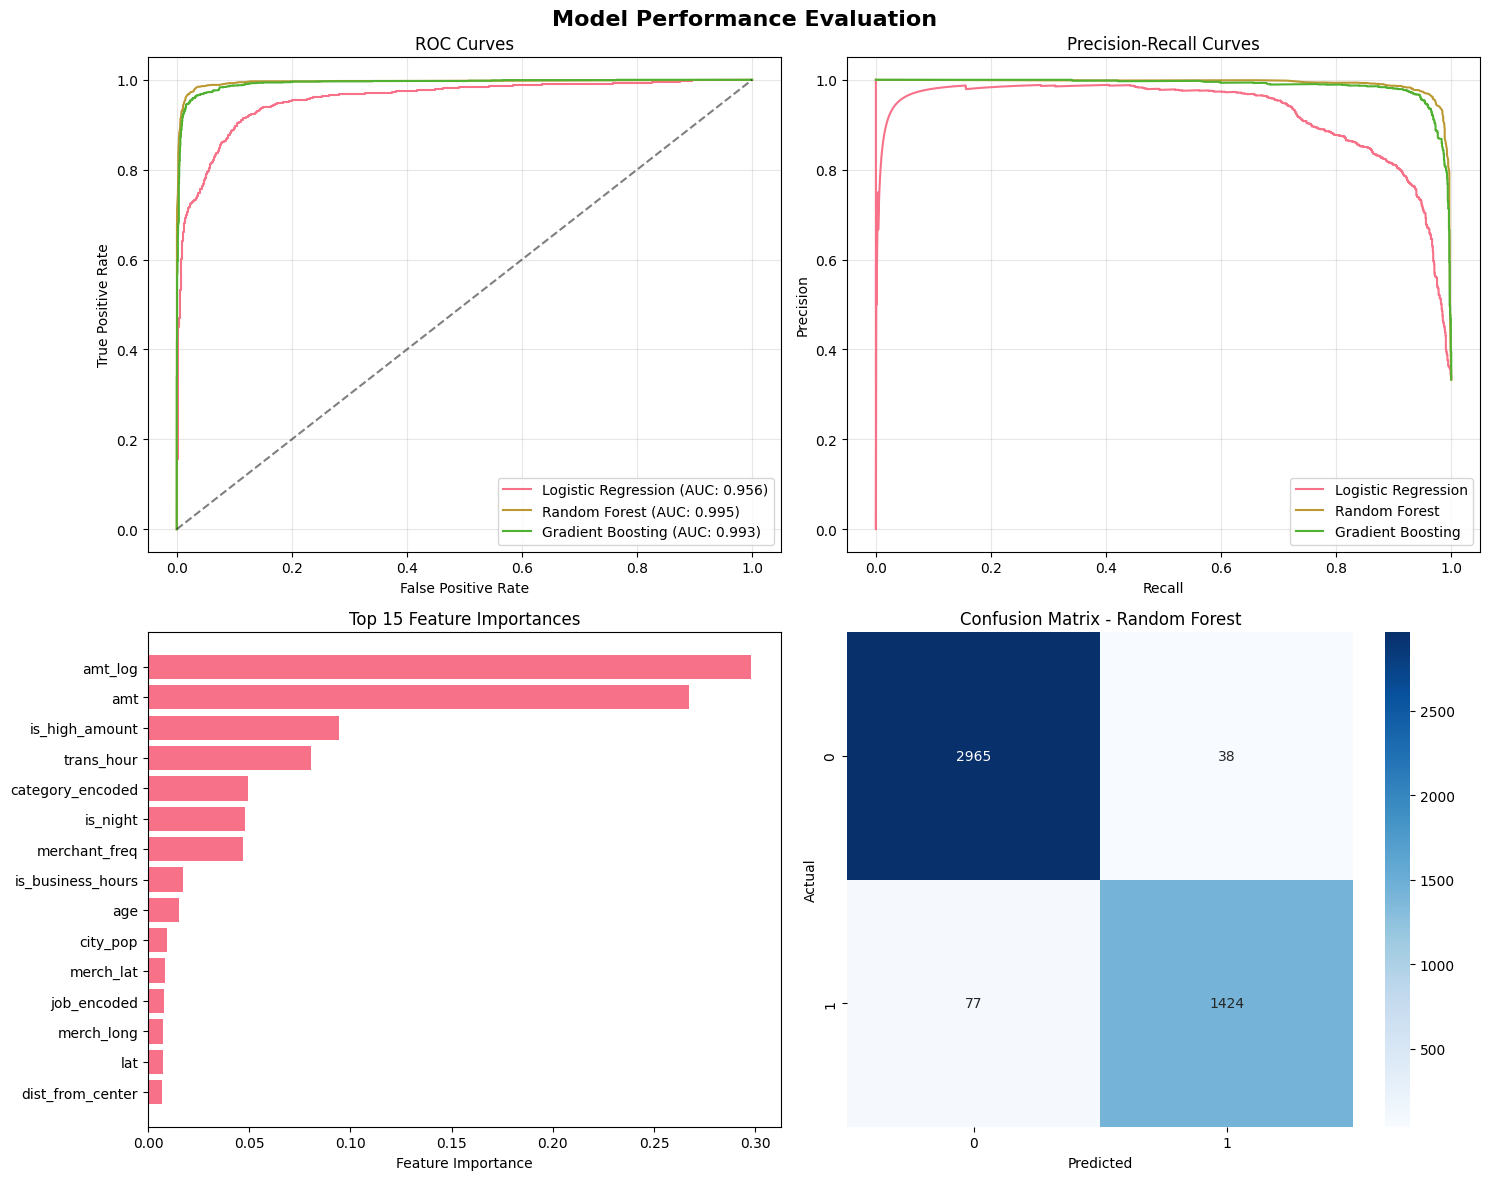


DETAILED RESULTS FOR RANDOM FOREST
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3003
           1       0.97      0.95      0.96      1501

    accuracy                           0.97      4504
   macro avg       0.97      0.97      0.97      4504
weighted avg       0.97      0.97      0.97      4504



In [11]:
# MODEL TRAINING AND EVALUATION

def train_and_evaluate_models(X_train, y_train, X_test=None):
    """
    Train multiple models and evaluate their performance
    """
    print("\n Training and evaluating models...")
    
    # Split training data for validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_split)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test) if X_test is not None else None
    
    # Define models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
    }
    
    results = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Use scaled data for Logistic Regression, original for tree-based models
        if name == 'Logistic Regression':
            model.fit(X_train_scaled, y_train_split)
            y_pred = model.predict(X_val_scaled)
            y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
        else:
            model.fit(X_train_split, y_train_split)
            y_pred = model.predict(X_val)
            y_pred_proba = model.predict_proba(X_val)[:, 1]
        
        # Calculate metrics
        auc_score = roc_auc_score(y_val, y_pred_proba)
        
        results[name] = {
            'model': model,
            'predictions': y_pred,
            'probabilities': y_pred_proba,
            'auc_score': auc_score,
            'classification_report': classification_report(y_val, y_pred)
        }
        
        print(f"✓ {name} AUC Score: {auc_score:.4f}")
    
    # Find best model
    best_model_name = max(results.keys(), key=lambda x: results[x]['auc_score'])
    best_model = results[best_model_name]['model']
    
    print(f"\n Best Model: {best_model_name} (AUC: {results[best_model_name]['auc_score']:.4f})")
    
    # Detailed evaluation plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Model Performance Evaluation', fontsize=16, fontweight='bold')
    
    # ROC Curves
    for name in results:
        fpr, tpr, _ = roc_curve(y_val, results[name]['probabilities'])
        axes[0,0].plot(fpr, tpr, label=f"{name} (AUC: {results[name]['auc_score']:.3f})")
    
    axes[0,0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[0,0].set_xlabel('False Positive Rate')
    axes[0,0].set_ylabel('True Positive Rate')
    axes[0,0].set_title('ROC Curves')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Precision-Recall Curves
    for name in results:
        precision, recall, _ = precision_recall_curve(y_val, results[name]['probabilities'])
        axes[0,1].plot(recall, precision, label=name)
    
    axes[0,1].set_xlabel('Recall')
    axes[0,1].set_ylabel('Precision')
    axes[0,1].set_title('Precision-Recall Curves')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Feature Importance (for best tree-based model)
    if 'Random Forest' in results or 'Gradient Boosting' in results:
        tree_model = results.get('Random Forest', results.get('Gradient Boosting'))['model']
        importances = tree_model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=True).tail(15)
        
        axes[1,0].barh(range(len(feature_importance_df)), feature_importance_df['importance'])
        axes[1,0].set_yticks(range(len(feature_importance_df)))
        axes[1,0].set_yticklabels(feature_importance_df['feature'])
        axes[1,0].set_xlabel('Feature Importance')
        axes[1,0].set_title('Top 15 Feature Importances')
    
    # Confusion Matrix for best model
    cm = confusion_matrix(y_val, results[best_model_name]['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,1])
    axes[1,1].set_xlabel('Predicted')
    axes[1,1].set_ylabel('Actual')
    axes[1,1].set_title(f'Confusion Matrix - {best_model_name}')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print(f"\n" + "="*60)
    print(f"DETAILED RESULTS FOR {best_model_name.upper()}")
    print("="*60)
    print(results[best_model_name]['classification_report'])
    
    return results, best_model, scaler

# Train models
if not df_train_processed.empty and y_train is not None:
    model_results, best_model, feature_scaler = train_and_evaluate_models(X_balanced, y_balanced, X_test)


 Generating final predictions using Random Forest...
✓ Predictions generated for 555,719 transactions
  Predicted fraud cases: 8,815 (1.59%)


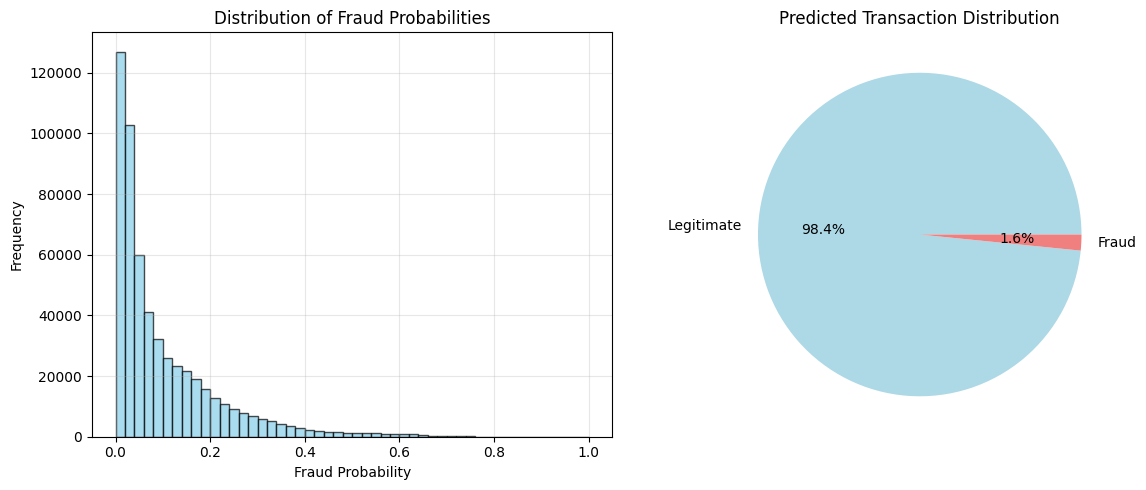

✓ Predictions saved to 'fraud_predictions.csv'


In [12]:
# FINAL PREDICTIONS AND SUBMISSION

def generate_predictions(model, scaler, X_test, model_name):
    """
    Generate final predictions for test set
    """
    print(f"\n Generating final predictions using {model_name}...")
    
    if X_test is None or X_test.empty:
        print(" No test data available for predictions")
        return None
    
    # Scale test data if needed
    if model_name == 'Logistic Regression':
        X_test_processed = scaler.transform(X_test)
    else:
        X_test_processed = X_test
    
    # Generate predictions
    predictions = model.predict(X_test_processed)
    prediction_probabilities = model.predict_proba(X_test_processed)[:, 1]
    
    # Create submission dataframe
    submission_df = pd.DataFrame({
        'transaction_id': range(len(predictions)),
        'is_fraud_prediction': predictions,
        'fraud_probability': prediction_probabilities
    })
    
    print(f"✓ Predictions generated for {len(predictions):,} transactions")
    print(f"  Predicted fraud cases: {predictions.sum():,} ({predictions.mean()*100:.2f}%)")
    
    # Show prediction distribution
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(prediction_probabilities, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Fraud Probability')
    plt.ylabel('Frequency')
    plt.title('Distribution of Fraud Probabilities')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    pred_counts = pd.Series(predictions).value_counts()
    plt.pie(pred_counts.values, labels=['Legitimate', 'Fraud'], autopct='%1.1f%%', 
            colors=['lightblue', 'lightcoral'])
    plt.title('Predicted Transaction Distribution')
    
    plt.tight_layout()
    plt.show()
    
    return submission_df

# Generate final predictions
if not df_train_processed.empty and y_train is not None and not df_test_processed.empty:
    submission = generate_predictions(best_model, feature_scaler, X_test, 
                                    max(model_results.keys(), key=lambda x: model_results[x]['auc_score']))
    
    if submission is not None:
        # Save predictions
        submission.to_csv('fraud_predictions.csv', index=False)
        print("✓ Predictions saved to 'fraud_predictions.csv'")

In [13]:
# MODEL INSIGHTS AND RECOMMENDATIONS

if not df_train_processed.empty and y_train is not None:
    print("\n KEY FINDINGS:")
    print(f"• Dataset contains {len(df_train_processed):,} transactions with {y_train.sum():,} fraud cases")
    print(f"• Fraud rate: {y_train.mean()*100:.2f}% (highly imbalanced dataset)")
    print(f"• Best performing model: {max(model_results.keys(), key=lambda x: model_results[x]['auc_score'])}")
    print(f"• Best AUC Score: {max(model_results.values(), key=lambda x: x['auc_score'])['auc_score']:.4f}")
    
    print("\n RECOMMENDATIONS:")
    print("• Deploy the best model for real-time fraud detection")
    print("• Set probability threshold based on business requirements (precision vs recall trade-off)")
    print("• Monitor model performance regularly and retrain with new data")
    print("• Consider ensemble methods for improved performance")
    print("• Implement feature monitoring to detect data drift")
    print("• Use explainable AI techniques for regulatory compliance")
    
    print("\n NEXT STEPS:")
    print("• A/B test the model in production with a small percentage of transactions")
    print("• Set up automated retraining pipeline")
    print("• Create monitoring dashboards for model performance")
    print("• Develop fallback rules for edge cases")
    print("• Regular feature engineering based on new fraud patterns")

else:
    print("\n  SETUP REQUIRED:")
    print("1. Ensure your CSV files ('df_train.csv' and 'df_test.csv') are in the correct directory")
    print("2. Update file paths in the data loading section if needed")
    print("3. Run the notebook again to see full analysis")
    print("\nThe notebook is ready to process your fraud detection dataset!")


print(f"\n{'='*80}")
print("FRAUD DETECTION PROJECT COMPLETE")
print(f"{'='*80}")


 KEY FINDINGS:
• Dataset contains 1,296,675 transactions with 7,506 fraud cases
• Fraud rate: 0.58% (highly imbalanced dataset)
• Best performing model: Random Forest
• Best AUC Score: 0.9951

 RECOMMENDATIONS:
• Deploy the best model for real-time fraud detection
• Set probability threshold based on business requirements (precision vs recall trade-off)
• Monitor model performance regularly and retrain with new data
• Consider ensemble methods for improved performance
• Implement feature monitoring to detect data drift
• Use explainable AI techniques for regulatory compliance

 NEXT STEPS:
• A/B test the model in production with a small percentage of transactions
• Set up automated retraining pipeline
• Create monitoring dashboards for model performance
• Develop fallback rules for edge cases
• Regular feature engineering based on new fraud patterns

FRAUD DETECTION PROJECT COMPLETE
